**1. Import Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

**2. Load Data**

In [5]:
try:
    df_processed = pd.read_csv('../data/processed_loan_data.csv')
    print(f"Processed data loaded. Shape: {df_processed.shape}")
except FileNotFoundError:
    print("Error: processed_loan_data.csv not found. Please run the preprocessing notebook first")
    df_processed = None

Processed data loaded. Shape: (65830, 57)


**3. Calculate Overall Default Rate**

Overall Default Rate: 56.55%


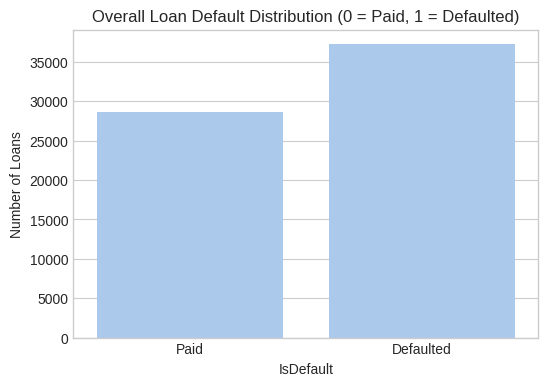

In [6]:
if df_processed is not None:
    default_rate = df_processed['IsDefault'].mean()
    print(f"Overall Default Rate: {default_rate:.2%}")
    
    #Bar chart for default rate
    plt.figure(figsize=(6, 4))
    sns.countplot(x='IsDefault', data=df_processed)
    plt.title('Overall Loan Default Distribution (0 = Paid, 1 = Defaulted)')
    plt.xticks(ticks=[0, 1], labels=['Paid', 'Defaulted'])
    plt.ylabel('Number of Loans')
    plt.show()
 

**4. Univariate Analysis**

a) Single Variables

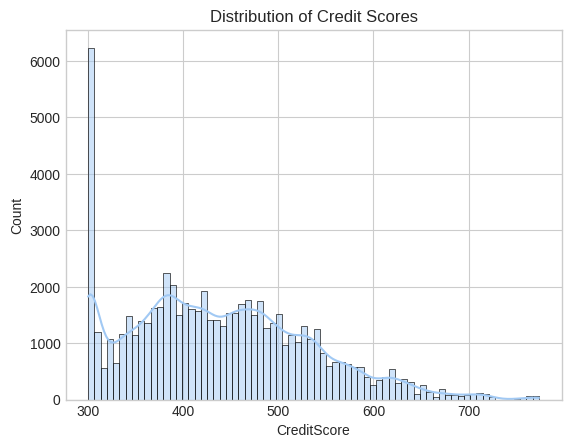

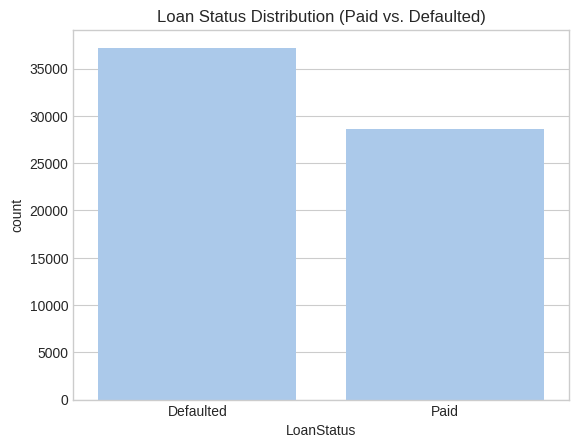

In [7]:
# Distribution of Credit Score
sns.histplot(df_processed['CreditScore'], kde=True)
plt.title('Distribution of Credit Scores')
plt.show()

# Count of Loan Status
sns.countplot(x='LoanStatus', data=df_processed)
plt.title('Loan Status Distribution (Paid vs. Defaulted)')
plt.show()

b) Numerical Features Against Default Status


Value distribution of MonthlyMobileMoneyVolume:
MonthlyMobileMoneyVolume
62746.19    5112
5873.05       48
24410.98      43
787.32        42
32724.14      42
Name: count, dtype: int64


/tmp/ipykernel_90727/2710664170.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bin = df_processed.groupby('MMVolume_Bin')['IsDefault'].mean().dropna()
/tmp/ipykernel_90727/2710664170.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=default_rate_by_bin.index, y=default_rate_by_bin.values, palette="viridis")


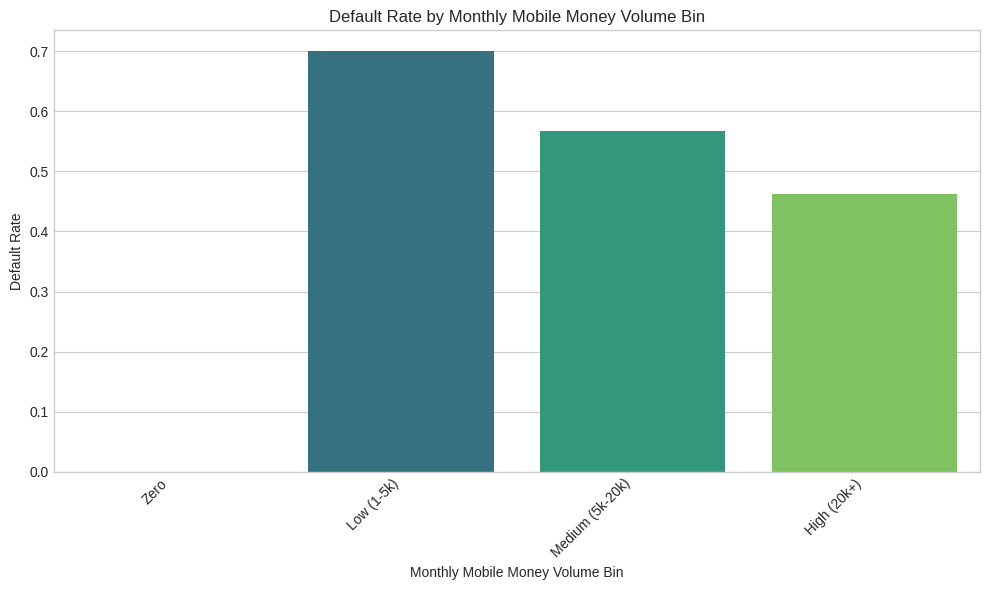

In [8]:
# Check if df_processed exists and is not empty
if 'df_processed' in locals() and df_processed is not None and 'MonthlyMobileMoneyVolume' in df_processed.columns:

    # --- DATA SANITIZATION (as before) ---
    negative_volume_count = (df_processed['MonthlyMobileMoneyVolume'] < 0).sum()
    if negative_volume_count > 0:
        print(f"Corrected {negative_volume_count} invalid negative values in 'MonthlyMobileMoneyVolume'.")
        df_processed['MonthlyMobileMoneyVolume'] = df_processed['MonthlyMobileMoneyVolume'].apply(lambda x: x if x >= 0 else 0)

    # --- Diagnostic: Check the distribution ---
    # This will show that most values are 0, which is why qcut fails.
    print("\nValue distribution of MonthlyMobileMoneyVolume:")
    print(df_processed['MonthlyMobileMoneyVolume'].value_counts().nlargest(5))

    # --- Binning with pd.cut (the correct method for this distribution) ---
    # We will manually define the bin edges.
    
    # Check if there are any non-zero values to bin
    max_volume = df_processed['MonthlyMobileMoneyVolume'].max()
    
    if max_volume > 0:
        # Create bins that handle the large number of zeros gracefully.
        # Bin 1: Just for zero
        # Bin 2: Low volume (e.g., 1 to 5000)
        # Bin 3: Medium volume (e.g., 5001 to 20000)
        # Bin 4: High volume (e.g., 20001+)
        bins = [-1, 0, 5000, 20000, max_volume + 1]
        labels = ['Zero', 'Low (1-5k)', 'Medium (5k-20k)', 'High (20k+)']
        
        df_processed['MMVolume_Bin'] = pd.cut(df_processed['MonthlyMobileMoneyVolume'], bins=bins, labels=labels, right=True)

        # --- Plotting the Default Rate by Bin ---
        plt.figure(figsize=(10, 6))
        
        # Calculate the default rate for each bin
        default_rate_by_bin = df_processed.groupby('MMVolume_Bin')['IsDefault'].mean().dropna()

        if not default_rate_by_bin.empty:
            sns.barplot(x=default_rate_by_bin.index, y=default_rate_by_bin.values, palette="viridis")
            plt.title('Default Rate by Monthly Mobile Money Volume Bin')
            plt.xlabel('Monthly Mobile Money Volume Bin')
            plt.ylabel('Default Rate')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print("\nCould not generate plot: No data falls into the defined bins or no defaults found.")

    else:
        print("\nSkipping plot: No non-zero 'MonthlyMobileMoneyVolume' data available to create bins.")

else:
    print("\nDataFrame 'df_processed' or column 'MonthlyMobileMoneyVolume' not found.")

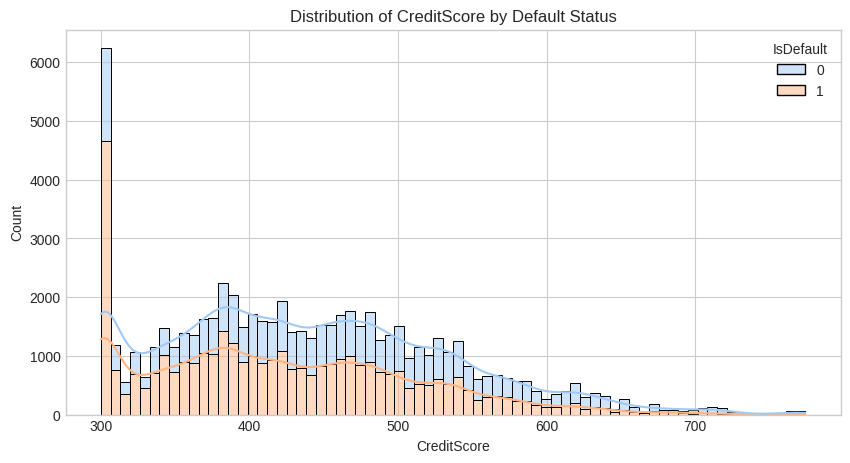

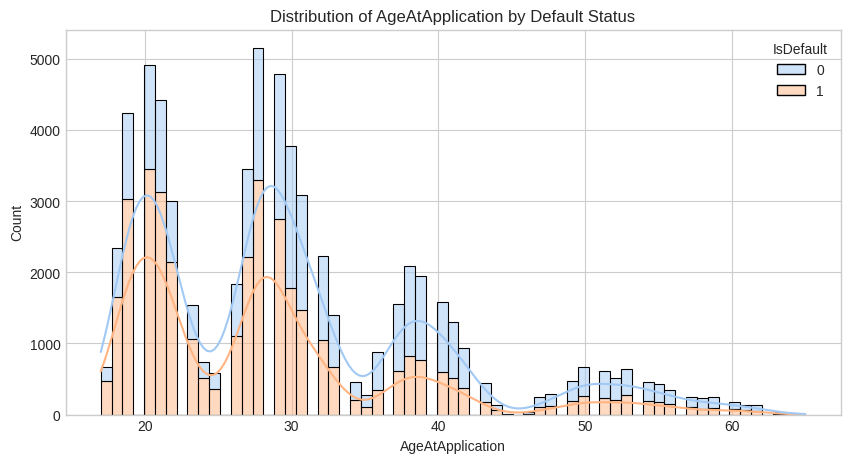

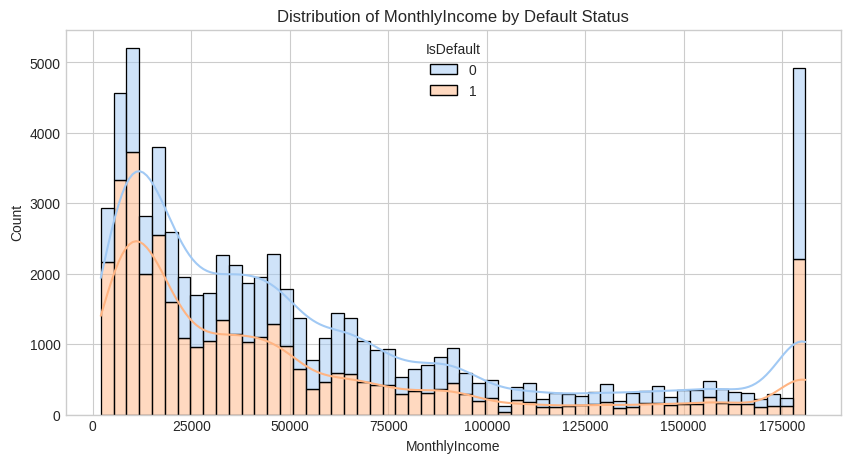

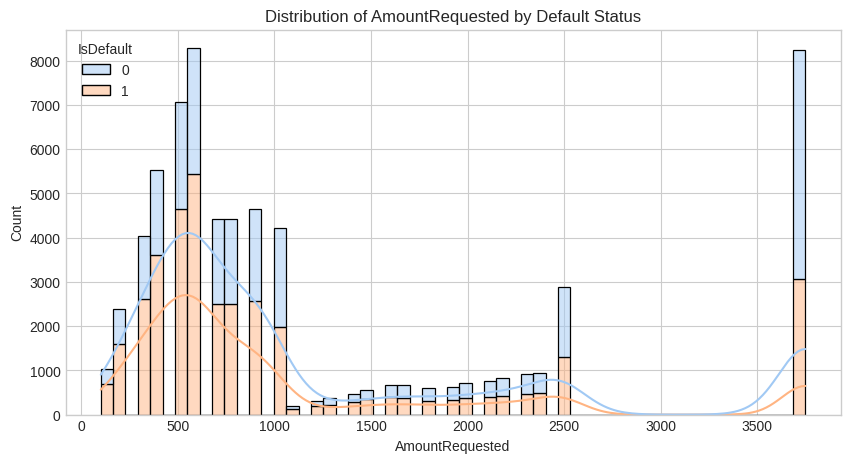

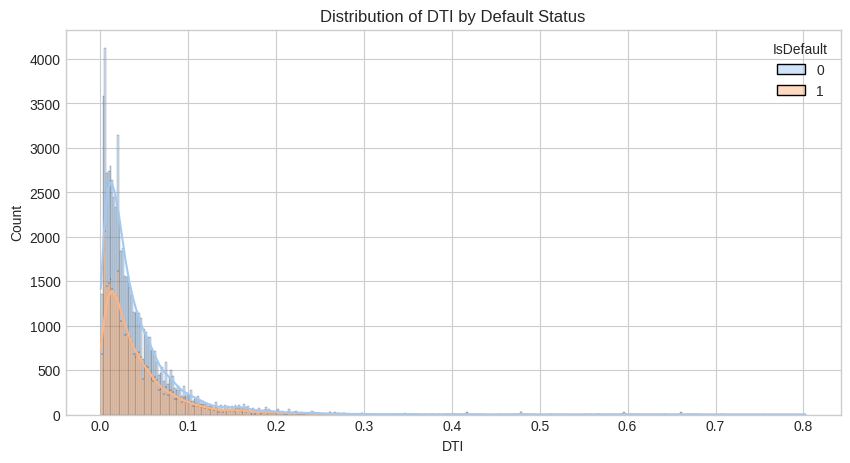

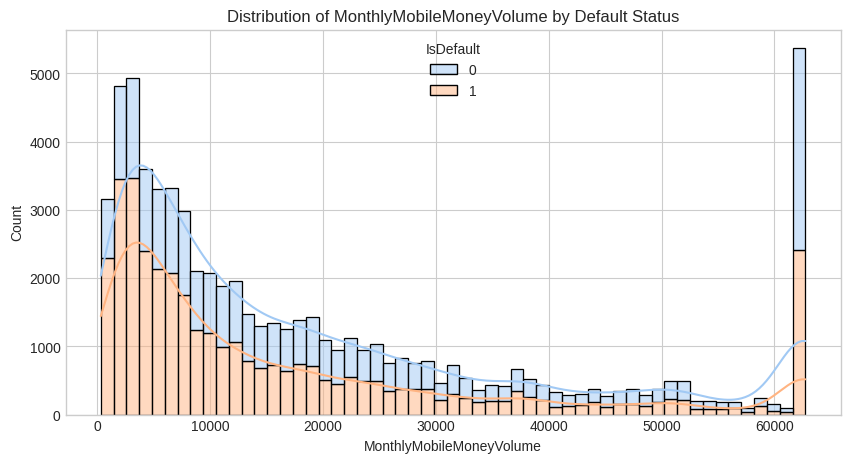

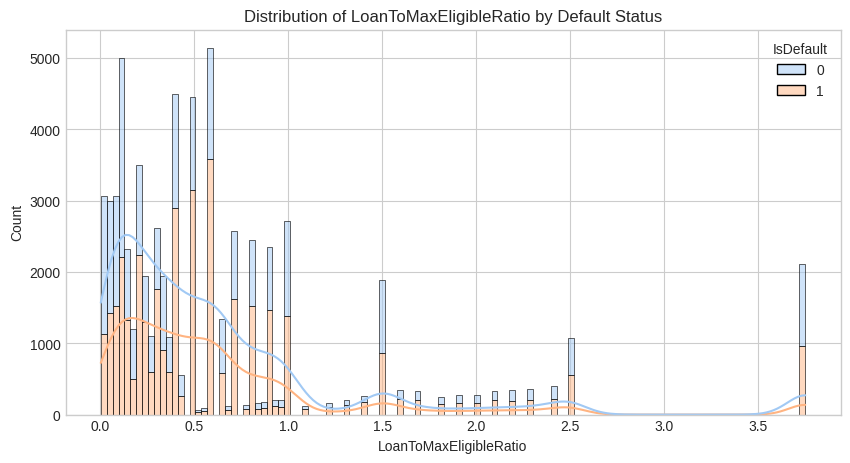

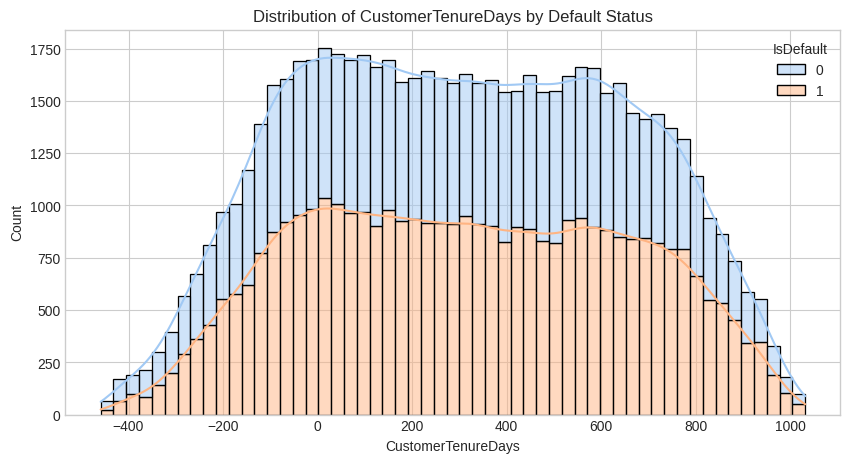

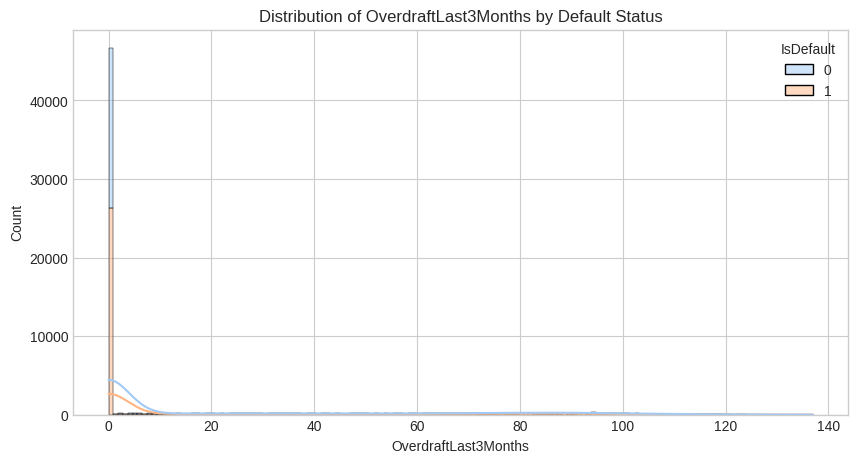

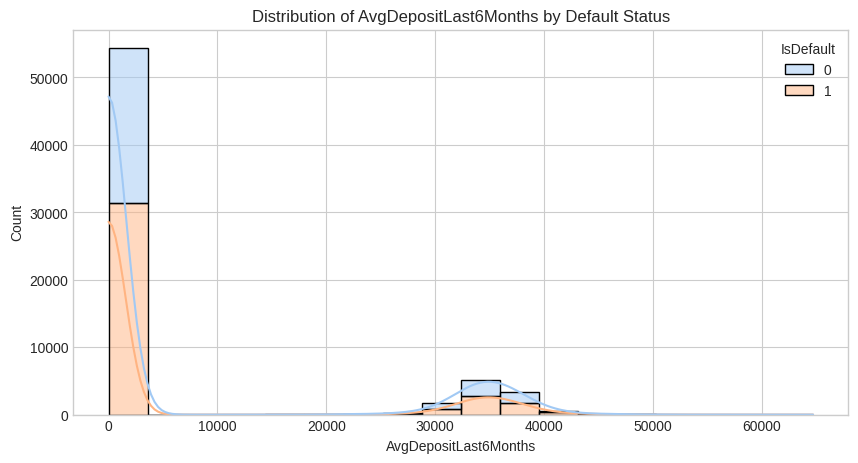

In [9]:
if df_processed is not None:
    numerical_features = ['CreditScore', 'AgeAtApplication', 'MonthlyIncome', 'AmountRequested', 'DTI', 'MonthlyMobileMoneyVolume',
                          'LoanToMaxEligibleRatio', 'CustomerTenureDays', 'OverdraftLast3Months', 'AvgDepositLast6Months']
    for col in numerical_features:
        if col in df_processed.columns:
            plt.figure(figsize=(10, 5))
            sns.histplot(data=df_processed, x=col, hue='IsDefault', kde=True, multiple="stack")
            plt.title(f'Distribution of {col} by Default Status')
            plt.show()
        else:
            print(f"Warning: Column {col} not found in Dataframe.")

Construct Boxplots for univariate analysis

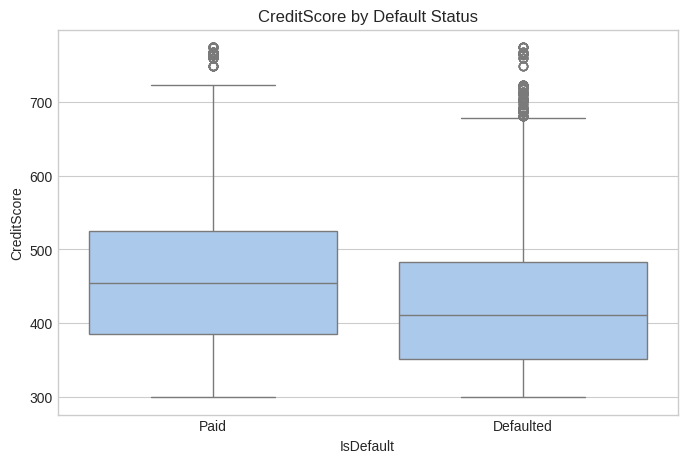

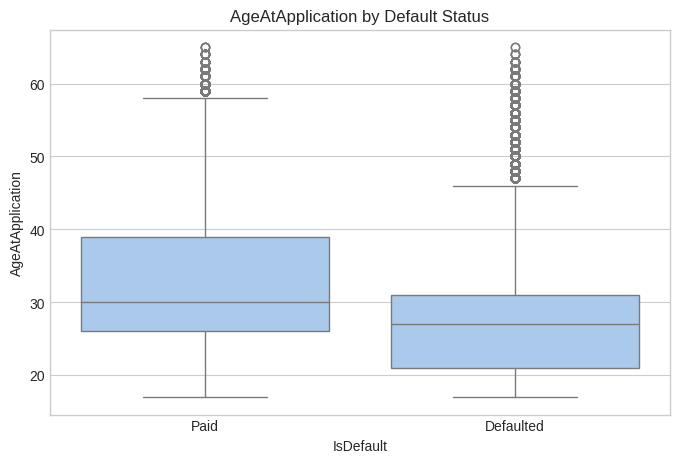

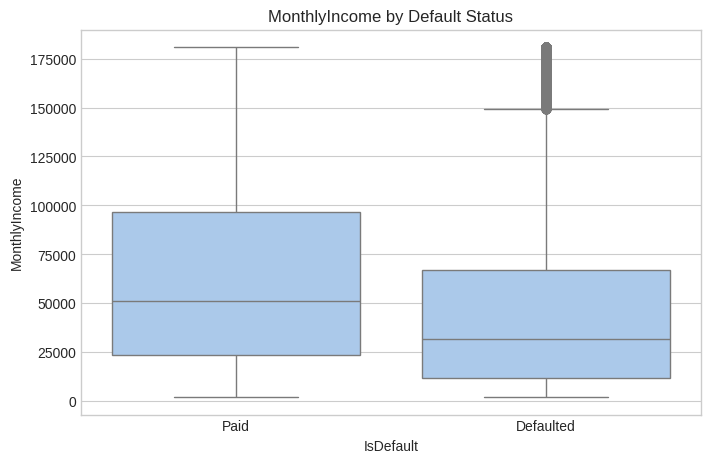

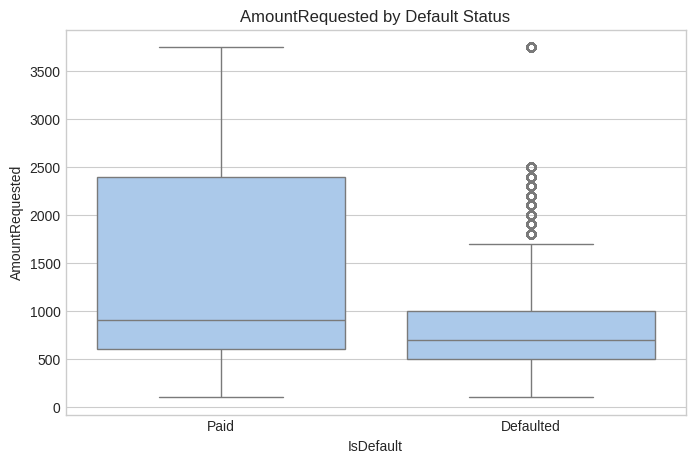

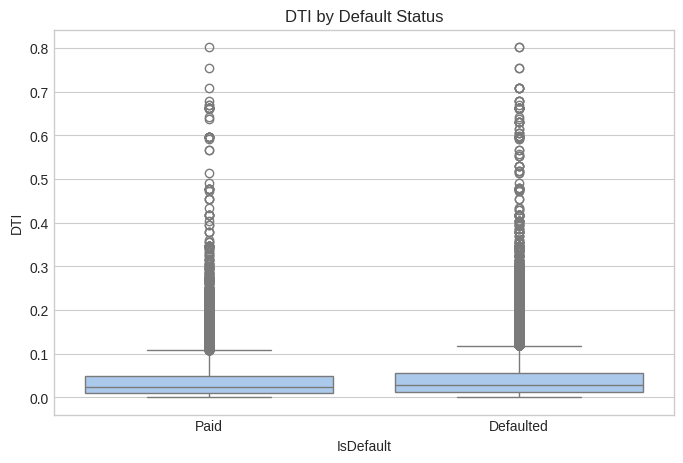

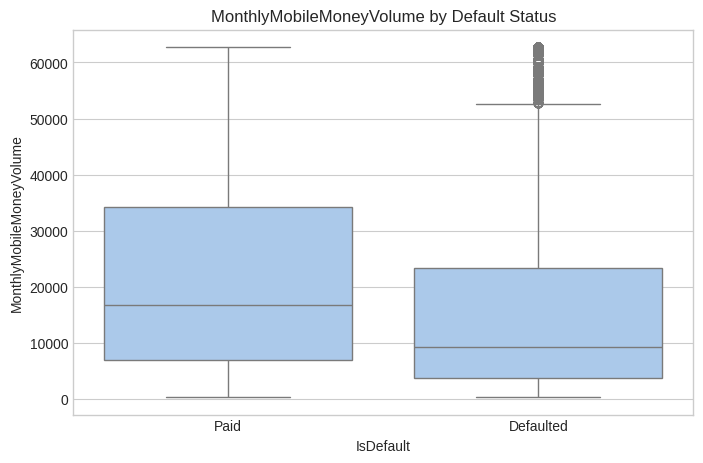

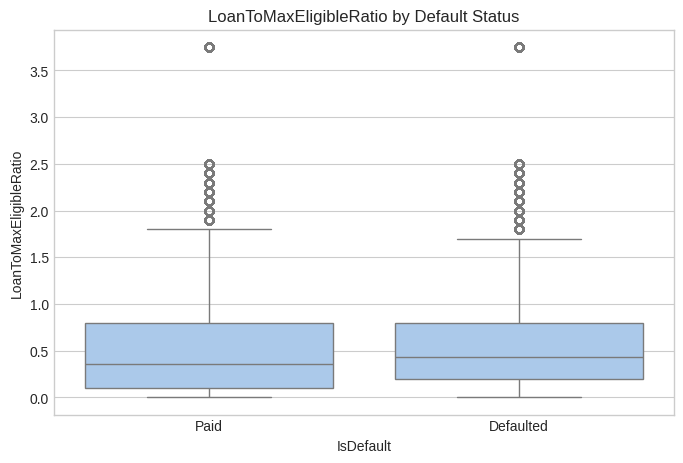

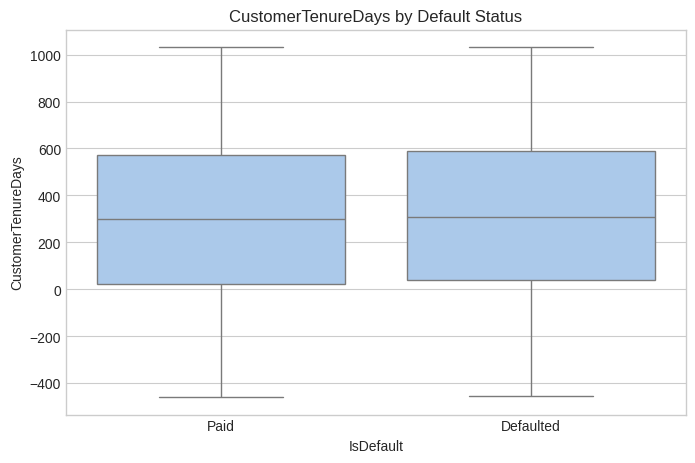

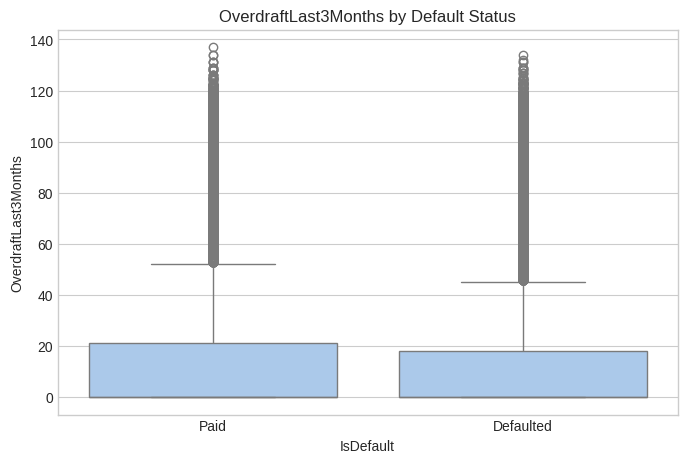

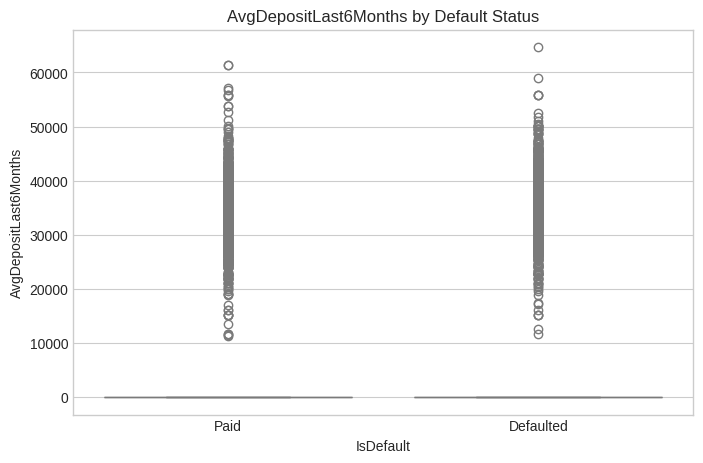

In [10]:
if df_processed is not None:
    for col in numerical_features:
        if col in df_processed.columns:
            plt.figure(figsize=(8, 5))
            sns.boxplot(x='IsDefault', y=col, data=df_processed)
            plt.title(f'{col} by Default Status')
            plt.xticks(ticks=[0, 1], labels=['Paid', 'Defaulted'])
            plt.show()
        else:
            print(f"Warning: Column {col} not found in Dataframe.")

MonthlyMobileMoneyVolume Aganst Default status

Descriptive Statistics for MonthlyMobileMoneyVolume (Original):
count    65830.000000
mean     19442.756703
std      18871.881714
min        301.910000
25%       4813.840000
50%      12084.300000
75%      27986.780000
max      62746.190000
Name: MonthlyMobileMoneyVolume, dtype: float64

--- Data Validation Before Plotting ---
Shape of data after dropping NaNs: (65830, 3)
Value counts of 'IsDefault' in the plot data:
IsDefault
1    37226
0    28604
Name: count, dtype: int64


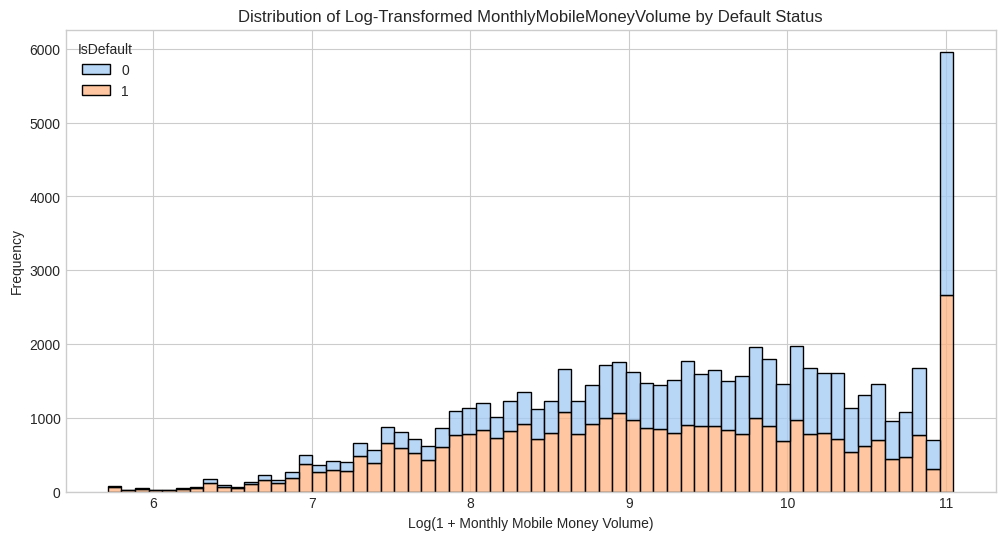

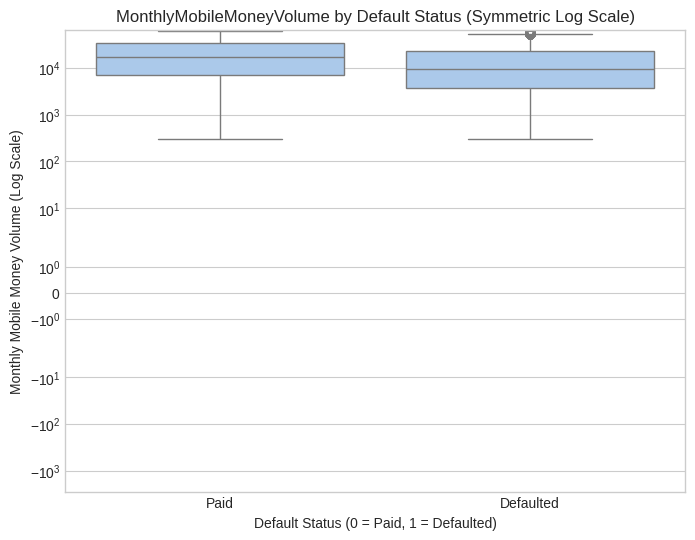

In [11]:
# Check if df_processed exists and is not empty
if 'df_processed' in locals() and df_processed is not None and not df_processed.empty:
    
    # --- Corrected Visualization for MonthlyMobileMoneyVolume ---

    print("Descriptive Statistics for MonthlyMobileMoneyVolume (Original):")
    print(df_processed['MonthlyMobileMoneyVolume'].describe())
    
    # --- DATA SANITIZATION ---
    # The output shows MonthlyMobileMoneyVolume contains negative values, which is impossible.
    # We will correct this by setting any negative values to 0 before proceeding.
    negative_volume_count = (df_processed['MonthlyMobileMoneyVolume'] < 0).sum()
    if negative_volume_count > 0:
        print(f"\nFound and corrected {negative_volume_count} invalid negative values in 'MonthlyMobileMoneyVolume'.")
        df_processed['MonthlyMobileMoneyVolume'] = df_processed['MonthlyMobileMoneyVolume'].apply(lambda x: x if x > 0 else 0)

    # Create a new column with a log+1 transformation for plotting
    df_processed['LogMonthlyMobileMoneyVolume'] = np.log1p(df_processed['MonthlyMobileMoneyVolume'])

    # --- Pre-Plotting Data Validation ---
    # Create a temporary dataframe for plotting to handle potential NaNs safely.
    plot_data = df_processed[['LogMonthlyMobileMoneyVolume', 'MonthlyMobileMoneyVolume', 'IsDefault']].copy()
    
    print("\n--- Data Validation Before Plotting ---")
    plot_data.dropna(subset=['LogMonthlyMobileMoneyVolume', 'IsDefault'], inplace=True)
    print(f"Shape of data after dropping NaNs: {plot_data.shape}")
    print("Value counts of 'IsDefault' in the plot data:")
    print(plot_data['IsDefault'].value_counts())
    
    # --- Plotting ---
    # Proceed only if there is data left to plot
    if not plot_data.empty and plot_data['IsDefault'].nunique() > 1:

        # --- Histogram Plot ---
        plt.figure(figsize=(12, 6))
        sns.histplot(data=plot_data, x='LogMonthlyMobileMoneyVolume', hue='IsDefault', kde=False, multiple="stack")
        plt.title('Distribution of Log-Transformed MonthlyMobileMoneyVolume by Default Status')
        plt.xlabel('Log(1 + Monthly Mobile Money Volume)')
        plt.ylabel('Frequency')
        plt.show()

        # --- Box Plot ---
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='IsDefault', y='MonthlyMobileMoneyVolume', data=plot_data)
        plt.yscale('symlog') # Use symmetric log scale to handle zeros
        plt.title('MonthlyMobileMoneyVolume by Default Status (Symmetric Log Scale)')
        plt.xlabel('Default Status (0 = Paid, 1 = Defaulted)')
        plt.ylabel('Monthly Mobile Money Volume (Log Scale)')
        plt.xticks(ticks=[0, 1], labels=['Paid', 'Defaulted'])
        plt.show()

    else:
        print("\nSkipping plots: Not enough valid data or only one 'IsDefault' category present after cleaning.")

else:
    print("DataFrame 'df_processed' not found or is empty. Please ensure it's loaded and processed correctly.")


**5. Bivariate Analysis (Categorical Features Against Default Rate)**

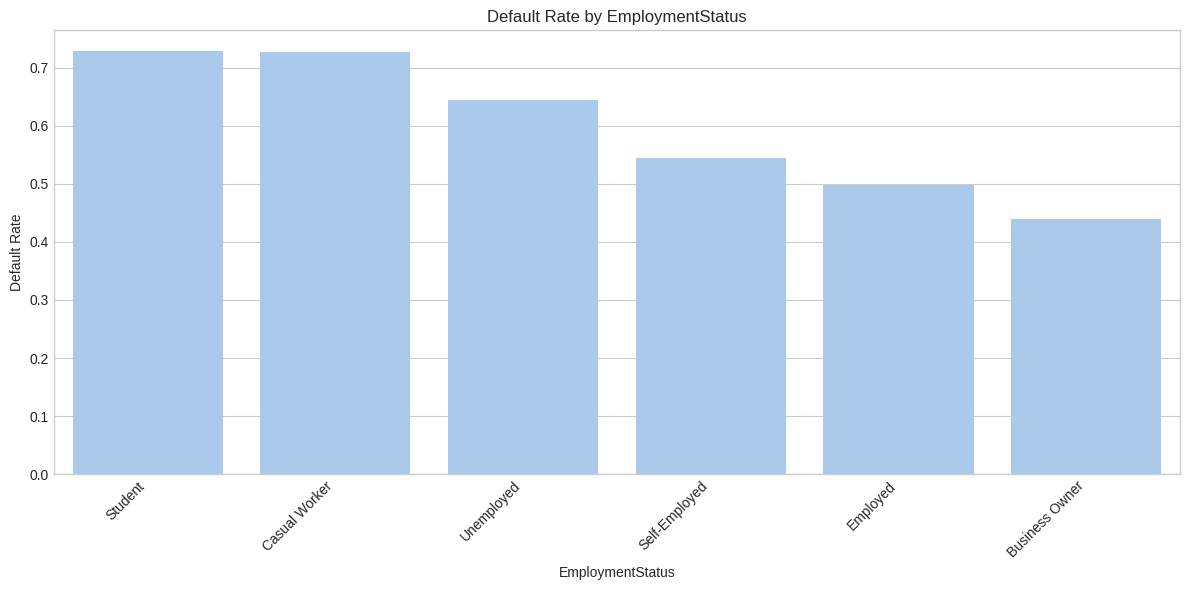

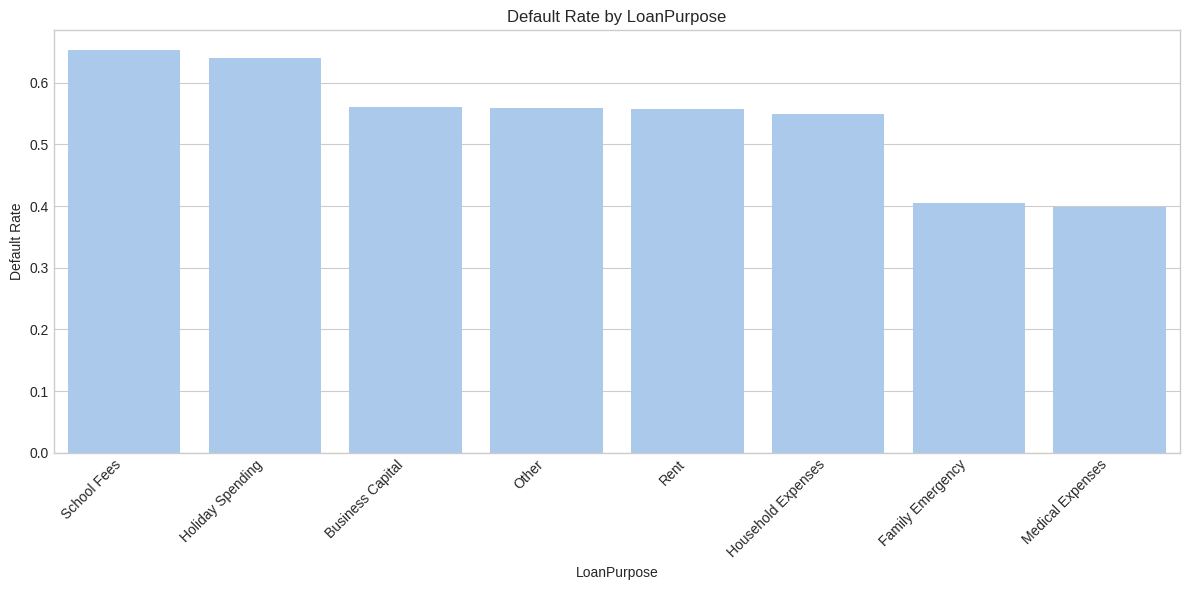

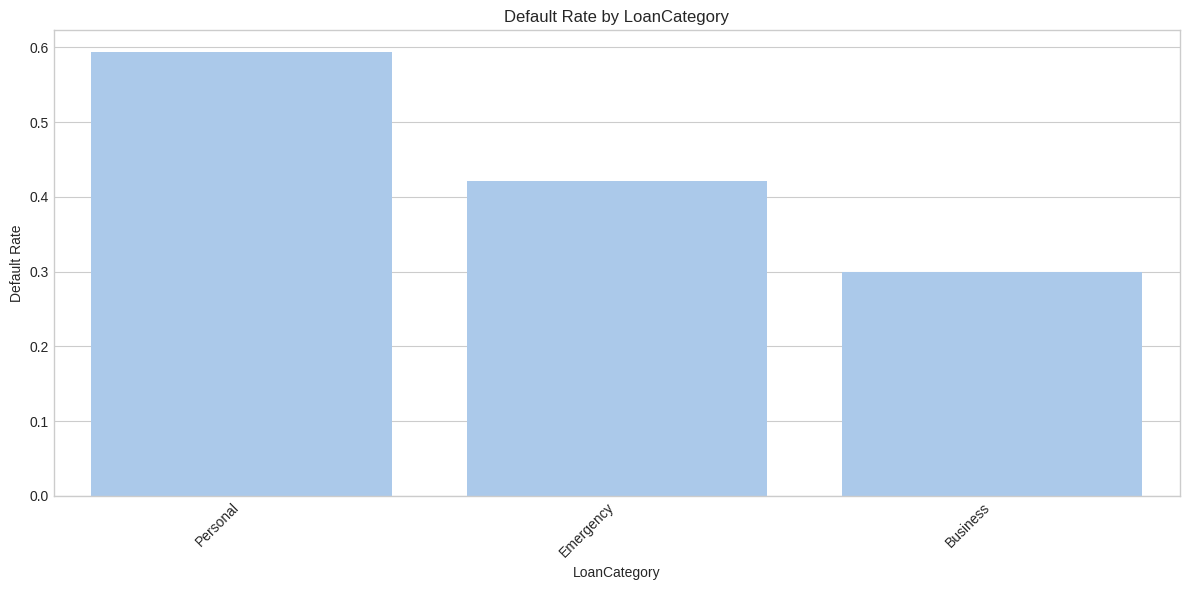

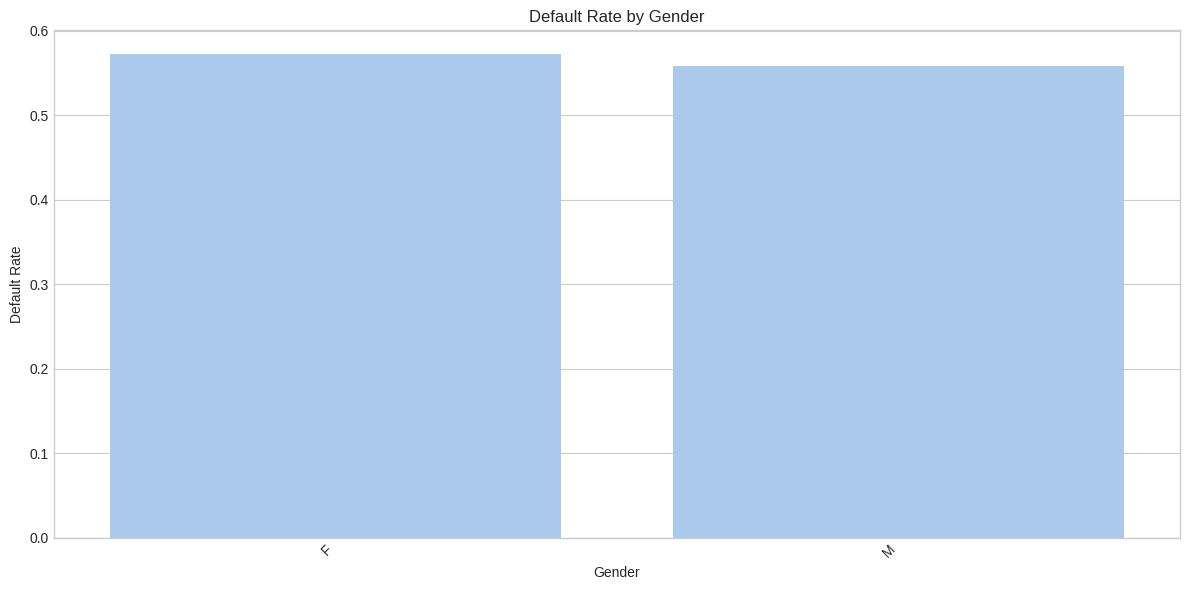

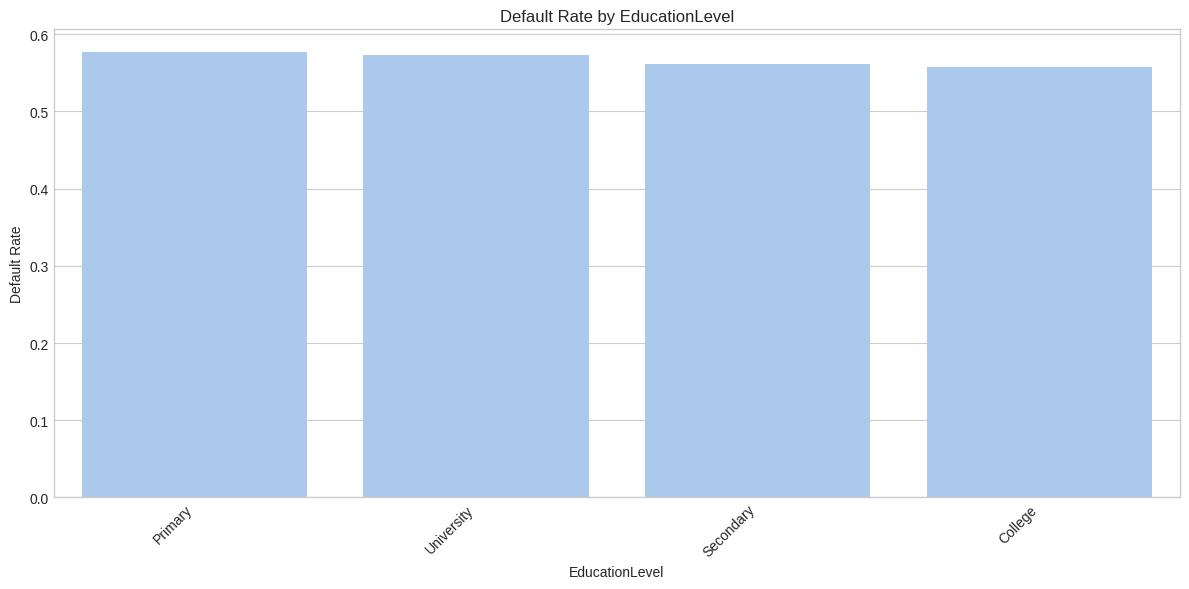

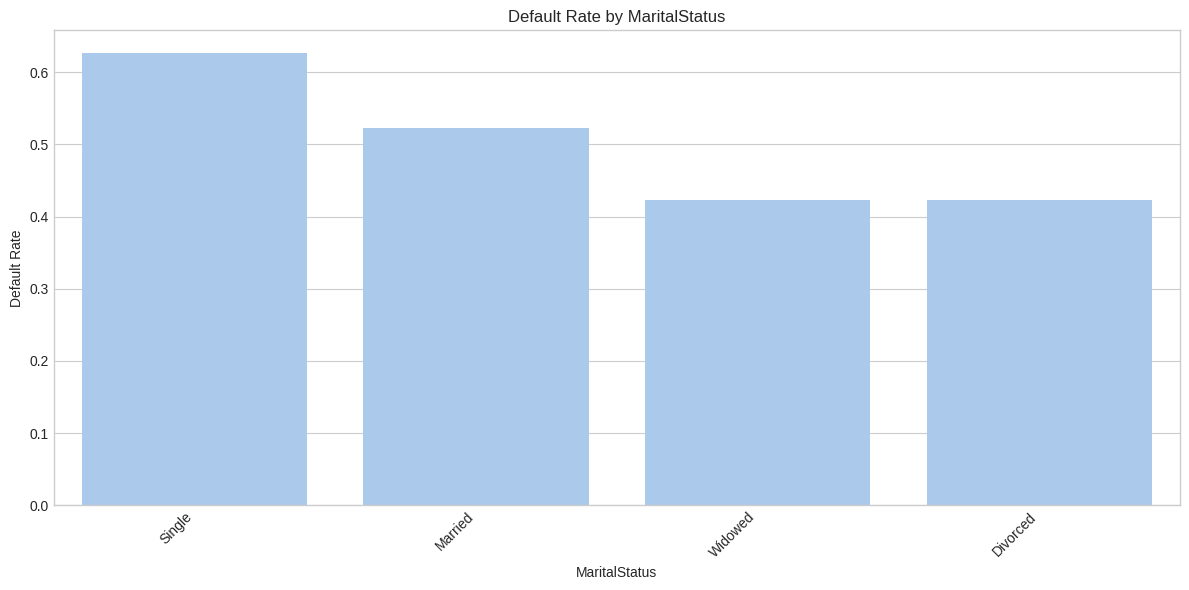

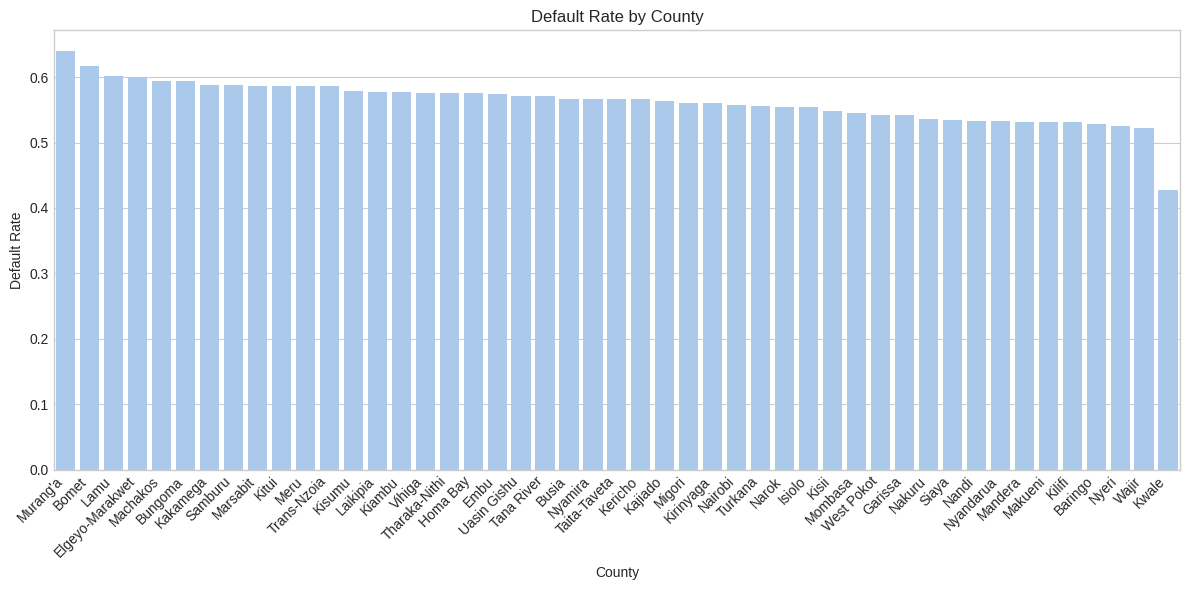

In [12]:
if df_processed is not None:
    categorical_features = ['EmploymentStatus', 'LoanPurpose', 'LoanCategory', 'Gender', 'EducationLevel', 'MaritalStatus', 'County'] 
    for col in categorical_features:
        if col in df_processed.columns:
            plt.figure(figsize=(12, 6))
            #Calculate default rate per category
            default_rate_by_cat = df_processed.groupby(col)['IsDefault'].mean().sort_values(ascending=False)
            sns.barplot(x=default_rate_by_cat.index, y=default_rate_by_cat.values)
            plt.title(f'Default Rate by {col}')
            plt.ylabel('Default Rate')
            plt.xlabel(col)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Column {col} not found in Dataframe. ")


Violin Plot - Full probability for employment status and credit score

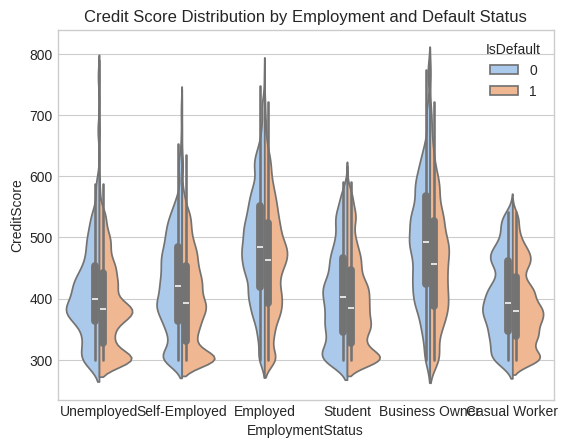

In [13]:
sns.violinplot(x='EmploymentStatus', y='CreditScore', hue='IsDefault', data=df_processed, split=True)
plt.title('Credit Score Distribution by Employment and Default Status')
plt.show()

Bivariate Analysis - Default Rate By MonthlyMobileMoneyVolume


Value distribution of MonthlyMobileMoneyVolume:
MonthlyMobileMoneyVolume
62746.19    5112
5873.05       48
24410.98      43
787.32        42
32724.14      42
Name: count, dtype: int64


/tmp/ipykernel_90727/2710664170.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bin = df_processed.groupby('MMVolume_Bin')['IsDefault'].mean().dropna()
/tmp/ipykernel_90727/2710664170.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=default_rate_by_bin.index, y=default_rate_by_bin.values, palette="viridis")


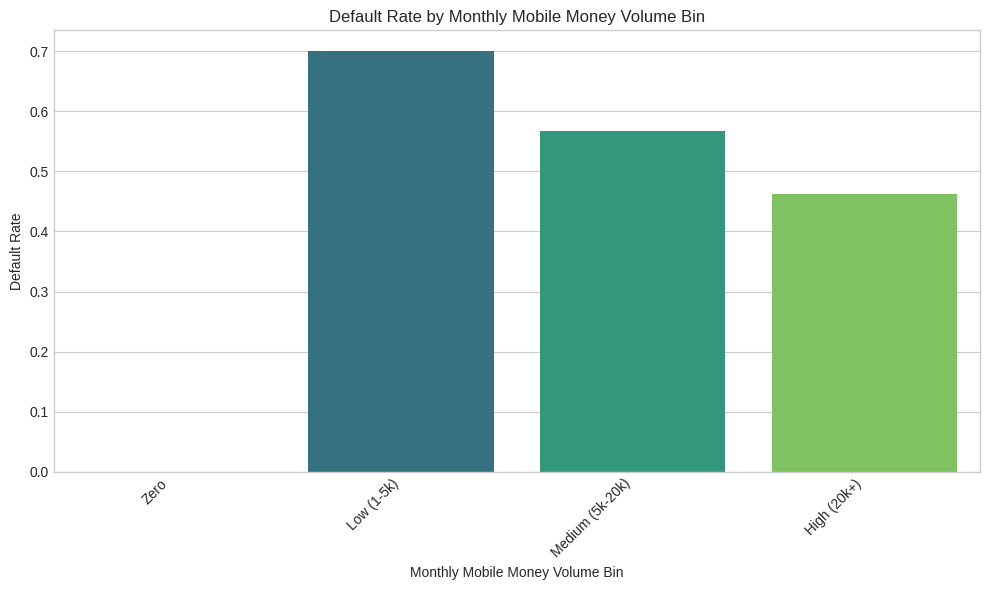

In [14]:
# Check if df_processed exists and is not empty
if 'df_processed' in locals() and df_processed is not None and 'MonthlyMobileMoneyVolume' in df_processed.columns:

    # --- DATA SANITIZATION (as before) ---
    negative_volume_count = (df_processed['MonthlyMobileMoneyVolume'] < 0).sum()
    if negative_volume_count > 0:
        print(f"Corrected {negative_volume_count} invalid negative values in 'MonthlyMobileMoneyVolume'.")
        df_processed['MonthlyMobileMoneyVolume'] = df_processed['MonthlyMobileMoneyVolume'].apply(lambda x: x if x >= 0 else 0)

    # --- Diagnostic: Check the distribution ---
    # This will show that most values are 0, which is why qcut fails.
    print("\nValue distribution of MonthlyMobileMoneyVolume:")
    print(df_processed['MonthlyMobileMoneyVolume'].value_counts().nlargest(5))

    # --- Binning with pd.cut (the correct method for this distribution) ---
    # We will manually define the bin edges.
    
    # Check if there are any non-zero values to bin
    max_volume = df_processed['MonthlyMobileMoneyVolume'].max()
    
    if max_volume > 0:
        # Create bins that handle the large number of zeros gracefully.
        # Bin 1: Just for zero
        # Bin 2: Low volume (e.g., 1 to 5000)
        # Bin 3: Medium volume (e.g., 5001 to 20000)
        # Bin 4: High volume (e.g., 20001+)
        bins = [-1, 0, 5000, 20000, max_volume + 1]
        labels = ['Zero', 'Low (1-5k)', 'Medium (5k-20k)', 'High (20k+)']
        
        df_processed['MMVolume_Bin'] = pd.cut(df_processed['MonthlyMobileMoneyVolume'], bins=bins, labels=labels, right=True)

        # --- Plotting the Default Rate by Bin ---
        plt.figure(figsize=(10, 6))
        
        # Calculate the default rate for each bin
        default_rate_by_bin = df_processed.groupby('MMVolume_Bin')['IsDefault'].mean().dropna()

        if not default_rate_by_bin.empty:
            sns.barplot(x=default_rate_by_bin.index, y=default_rate_by_bin.values, palette="viridis")
            plt.title('Default Rate by Monthly Mobile Money Volume Bin')
            plt.xlabel('Monthly Mobile Money Volume Bin')
            plt.ylabel('Default Rate')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print("\nCould not generate plot: No data falls into the defined bins or no defaults found.")

    else:
        print("\nSkipping plot: No non-zero 'MonthlyMobileMoneyVolume' data available to create bins.")

else:
    print("\nDataFrame 'df_processed' or column 'MonthlyMobileMoneyVolume' not found.")

Credit Score for Defaulters Aganinst Non-Defaulters

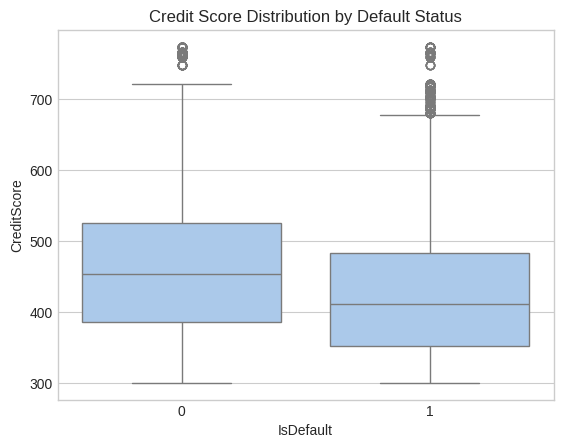

In [15]:
# Credit Score for Defaulters vs. Non-Defaulters
sns.boxplot(x='IsDefault', y='CreditScore', data=df_processed)
plt.title('Credit Score Distribution by Default Status')
plt.show()

DTI Against Default Status

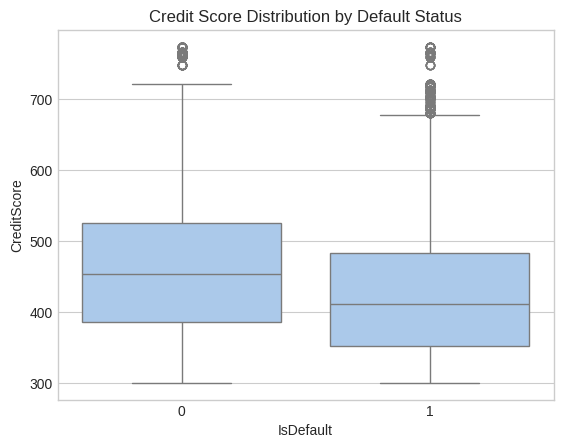

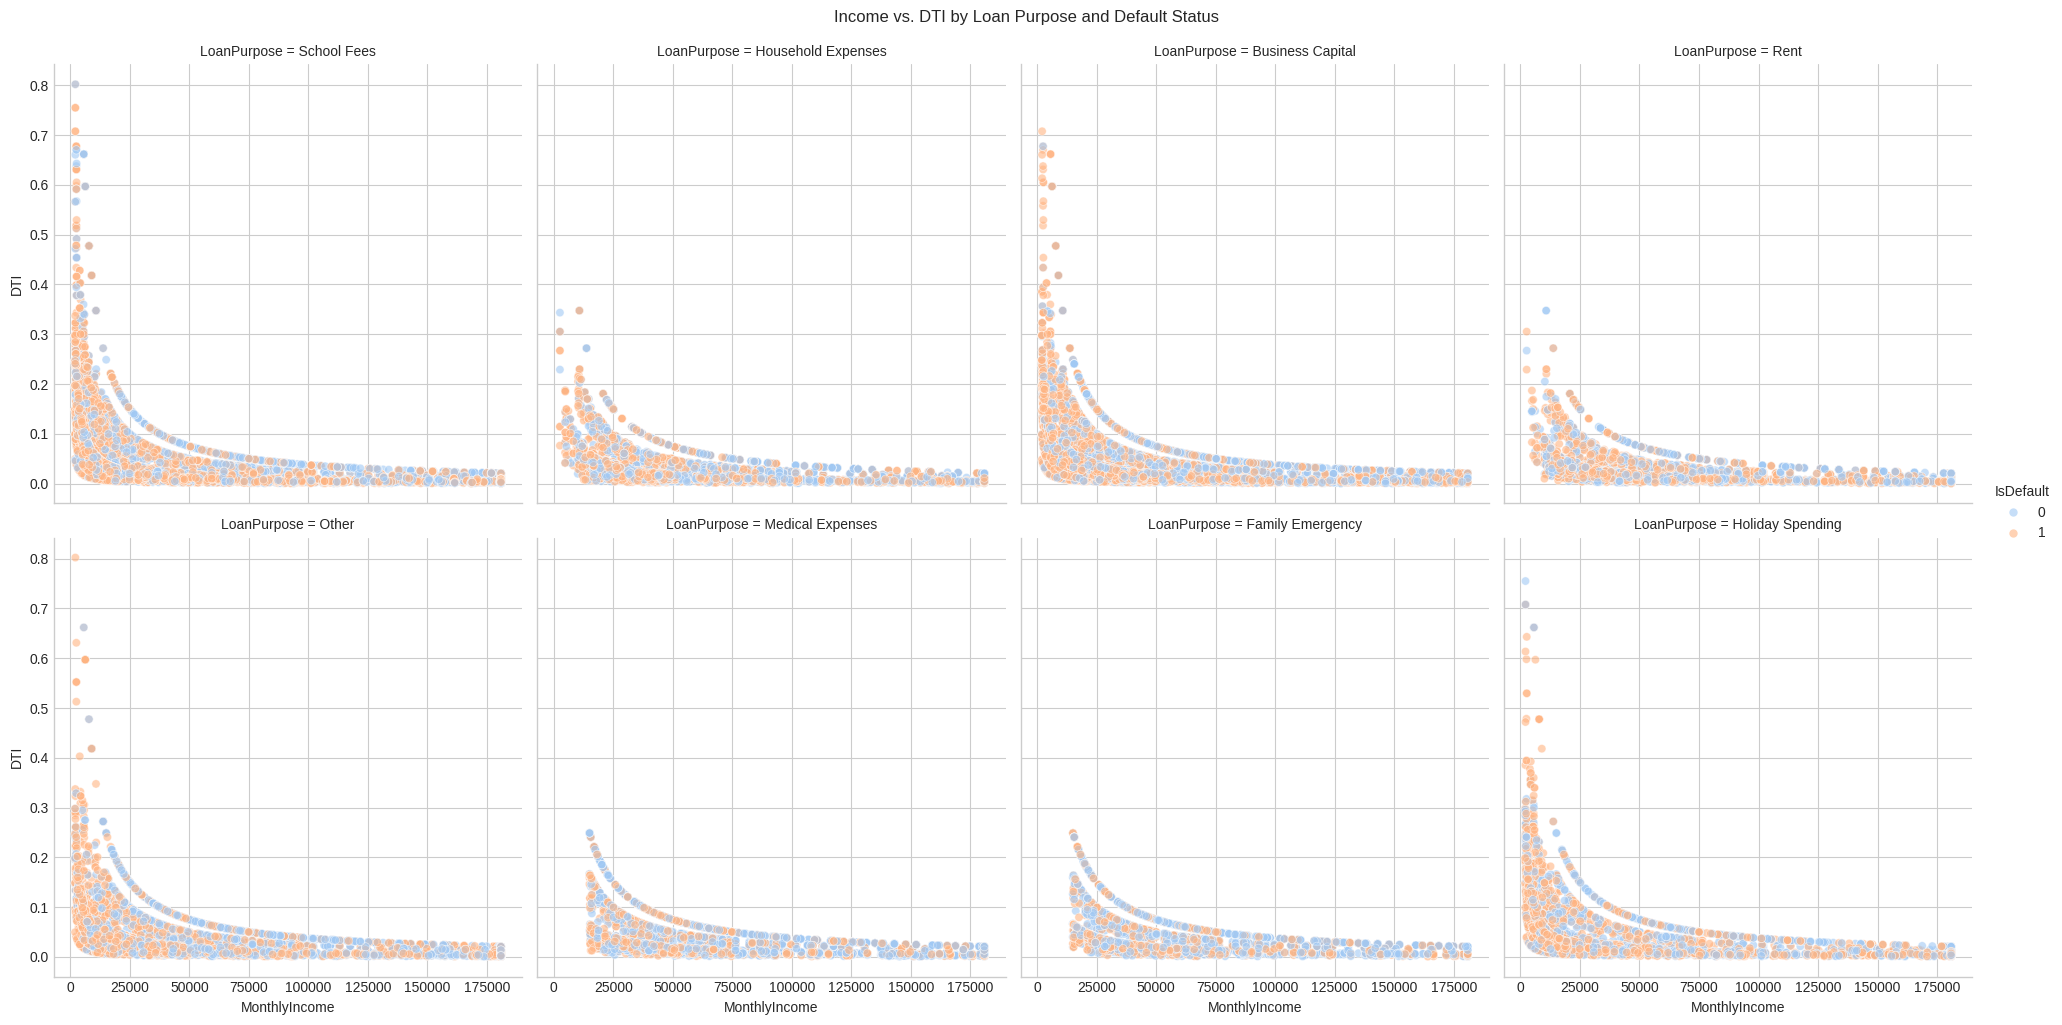

In [16]:
# Credit Score for Defaulters vs. Non-Defaulters
sns.boxplot(x='IsDefault', y='CreditScore', data=df_processed)
plt.title('Credit Score Distribution by Default Status')
plt.show()

# See how DTI's effect on default changes across different loan purposes
sns.relplot(
    data=df_processed, x='MonthlyIncome', y='DTI',
    hue='IsDefault', col='LoanPurpose', col_wrap=4,
    kind='scatter', alpha=0.6
)
plt.suptitle('Income vs. DTI by Loan Purpose and Default Status', y=1.02)
plt.show()

**6. Correlation Analysis**

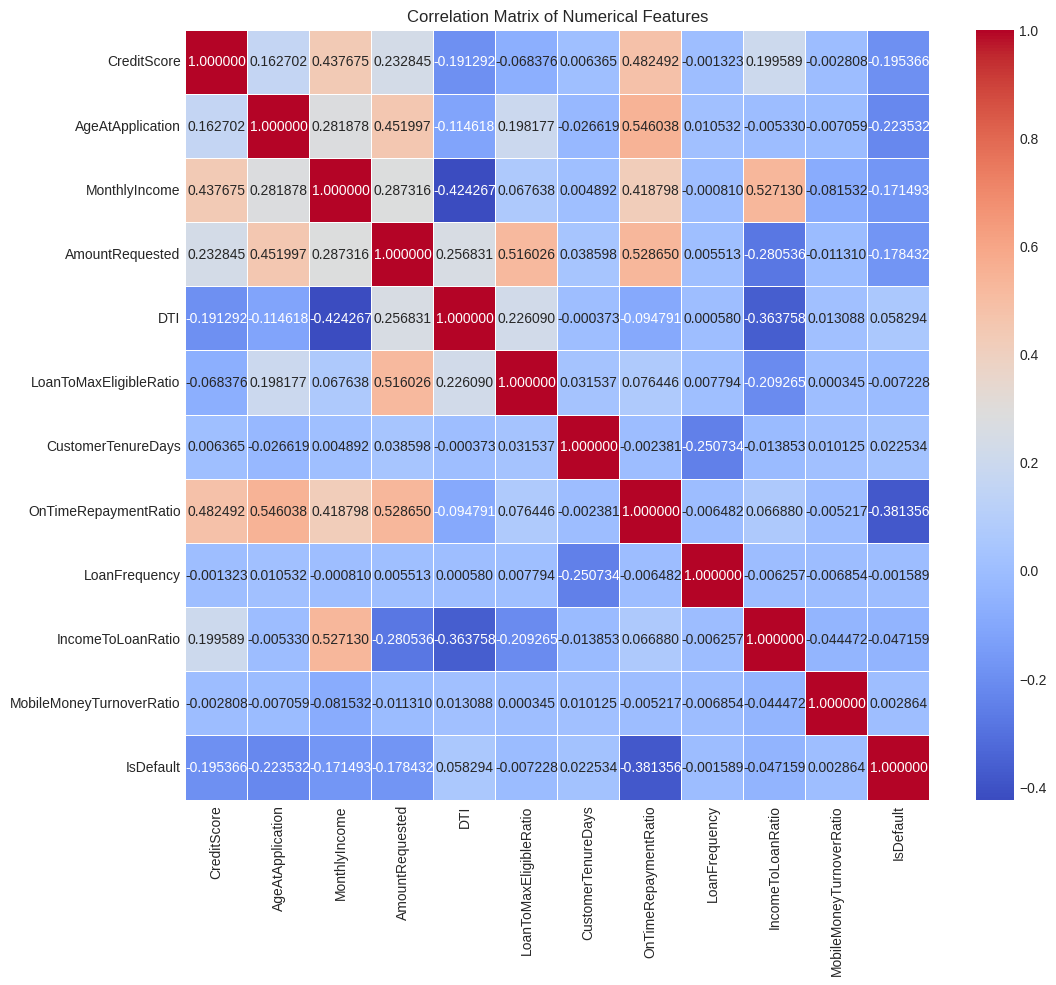

Correlation with IsDefault: 
IsDefault                   1.000000
DTI                         0.058294
CustomerTenureDays          0.022534
MobileMoneyTurnoverRatio    0.002864
LoanFrequency              -0.001589
LoanToMaxEligibleRatio     -0.007228
IncomeToLoanRatio          -0.047159
MonthlyIncome              -0.171493
AmountRequested            -0.178432
CreditScore                -0.195366
AgeAtApplication           -0.223532
OnTimeRepaymentRatio       -0.381356
Name: IsDefault, dtype: float64


In [17]:
#Select only numerical columns for the correltaion matrix
#Include your target variable 'IsDefault' and newly engineered features
numerical_cols_for_corr = [
    'CreditScore', 'AgeAtApplication', 'MonthlyIncome', 'AmountRequested', 'DTI', 
    'LoanToMaxEligibleRatio', 'CustomerTenureDays', 'OnTimeRepaymentRatio', 
    'LoanFrequency', 'IncomeToLoanRatio', 'MobileMoneyTurnoverRatio', 'IsDefault'
]

#Ensure all selected columns  are in the dataframe
valid_cols = [col for col in numerical_cols_for_corr if col in df_processed.columns]

#Create the correlation matrix
corr_matrix =  df_processed[valid_cols].corr()

#Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#Display the correlation with the target variable
print("Correlation with IsDefault: ")
print(corr_matrix['IsDefault'].sort_values(ascending=False))

In [18]:
if 'df_processed' in locals() and df_processed is not None and 'MonthlyMobileMoneyVolume' in df_processed.columns:
    group_defaulted = df_processed[df_processed['IsDefault'] == 1]['MonthlyMobileMoneyVolume'].dropna()
    group_paid = df_processed[df_processed['IsDefault'] == 0]['MonthlyMobileMoneyVolume'].dropna()

    if len(group_defaulted) > 0 and len(group_paid) > 0:
        u_statistic, p_value = mannwhitneyu(group_defaulted, group_paid, alternative='less') # Testing if defaulted group has 'less' volume

        print(f"\nMann-Whitney U Test for MonthlyMobileMoneyVolume (Defaulters vs. Paid):")
        print(f"U-statistic: {u_statistic}")
        print(f"P-value: {p_value}")

        if p_value < 0.05:
            print("The p-value is < 0.05, suggesting a statistically significant difference: Customers who defaulted tend to have lower MonthlyMobileMoneyVolume than those who paid.")
        else:
            print("The p-value is >= 0.05, suggesting no statistically significant difference in MonthlyMobileMoneyVolume between the groups based on this test, or that defaulters do not have significantly 'less' volume.")
    else:
        print("Not enough data in one or both groups to perform Mann-Whitney U test for MonthlyMobileMoneyVolume.")


Mann-Whitney U Test for MonthlyMobileMoneyVolume (Defaulters vs. Paid):
U-statistic: 412769967.0
P-value: 0.0
The p-value is < 0.05, suggesting a statistically significant difference: Customers who defaulted tend to have lower MonthlyMobileMoneyVolume than those who paid.


**7. Cohort Analysis**

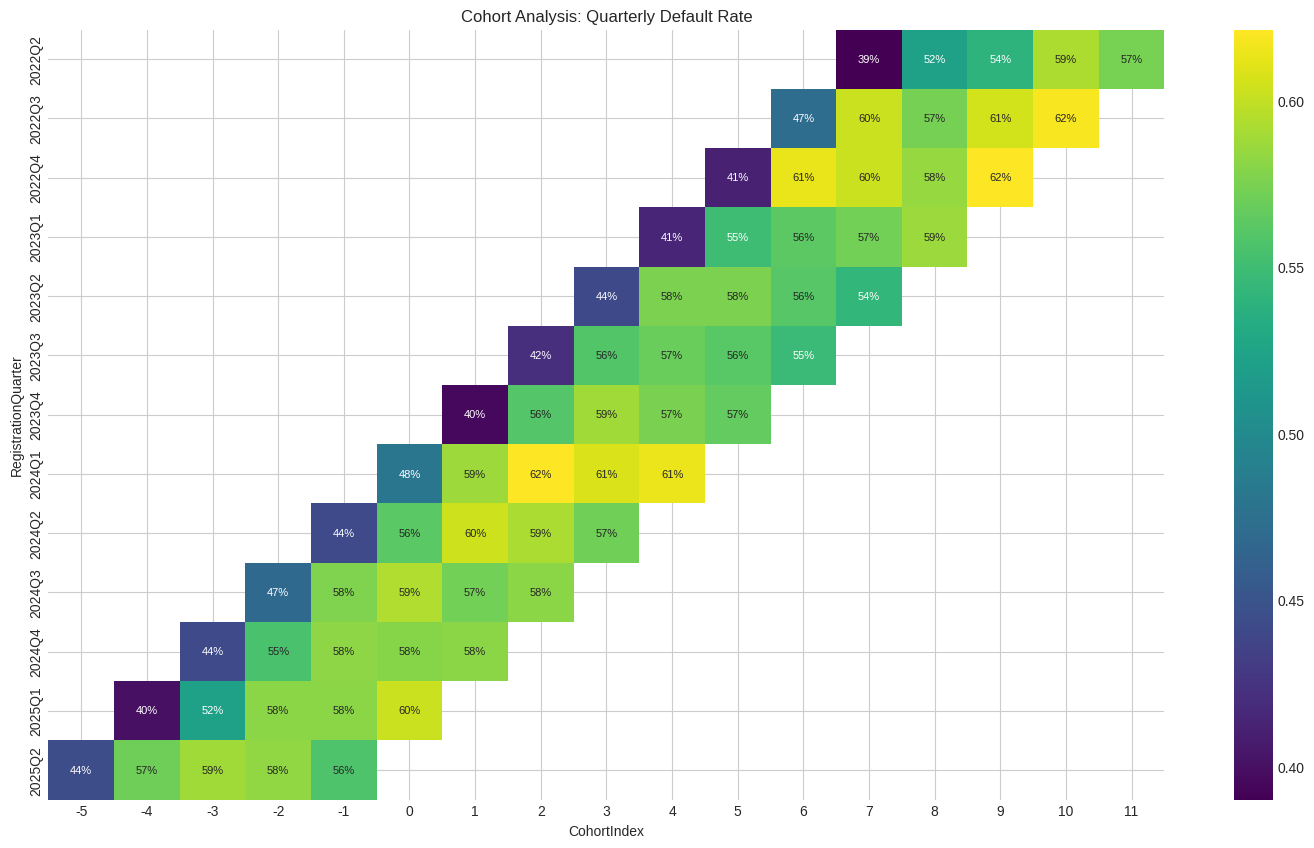

In [21]:
#Create Cohorts
df_processed['RegistrationQuarter'] = pd.to_datetime(df_processed['CustomerRegistrationDate']).dt.to_period('Q')

#Calculate Cohort Index
df_processed['ApplicationQuarter'] = pd.to_datetime(df_processed['ApplicationDate']).dt.to_period('Q')
df_processed['CohortIndex'] = (df_processed['ApplicationQuarter'] - df_processed['RegistrationQuarter']).apply(lambda x: x.n)

#Pivot the Data
cohort_data = df_processed.groupby(['RegistrationQuarter', 'CohortIndex'])['IsDefault'].mean().reset_index()
cohort_pivot = cohort_data.pivot_table(index='RegistrationQuarter', columns='CohortIndex', values='IsDefault')

#Construct Heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(cohort_pivot, annot=True, fmt='.0%', cmap='viridis', annot_kws={"size": 8})
plt.title('Cohort Analysis: Quarterly Default Rate')
plt.show()
